In [1]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
#         print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
#         print(f_idxs)
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [2]:
import pandas as pd
from pandas import DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import math
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
plt.rcParams['figure.figsize'] = (15, 9)
%matplotlib inline

In [3]:
amzn_df = pd.read_csv("AMZN_long.csv")
snp = pd.read_csv("GSPC.csv")

In [4]:
amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,311.570007,316.559998,304.820007,306.640015,306.640015,3639200
1,2014-12-09,302.989990,313.640015,301.140015,312.500000,312.500000,4049500
2,2014-12-10,312.000000,313.190002,304.679993,305.839996,305.839996,3245900
3,2014-12-11,307.890015,312.640015,306.010010,307.359985,307.359985,3262900
4,2014-12-12,303.989990,310.640015,303.010010,307.320007,307.320007,3153500


In [5]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null object
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [6]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null object
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [7]:
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
snp['Date'] = pd.to_datetime(snp['Date'])

In [8]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null datetime64[ns]
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [9]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null datetime64[ns]
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [10]:
amzn_df.index=DatetimeIndex(amzn_df['Date'])
snp.index=DatetimeIndex(snp['Date'])

In [11]:
X = amzn_df

In [12]:
X['Stock_Price'] = (2*amzn_df.High + amzn_df.Low + amzn_df.Close)/4

In [13]:
X['SP500'] = (2*snp.High + snp.Low + snp.Close)/4

In [14]:
from sklearn.preprocessing import StandardScaler
col_names = ['SP500']
features = X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [15]:
X[col_names] = features

In [16]:
X.drop(columns=['Date', 'Open', 'High', 'Low', 'Close','Adj Close'],inplace=True)

In [17]:
X.head()

,Volume,Stock_Price,SP500
Date,,,
2014-12-08,3639200,311.145004,-1.066512
2014-12-09,4049500,310.230011,-1.102944
2014-12-10,3245900,309.224998,-1.136603
2014-12-11,3262900,309.662506,-1.132177
2014-12-12,3153500,307.902512,-1.207366


/Users/scarstruck/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Stock_Price')

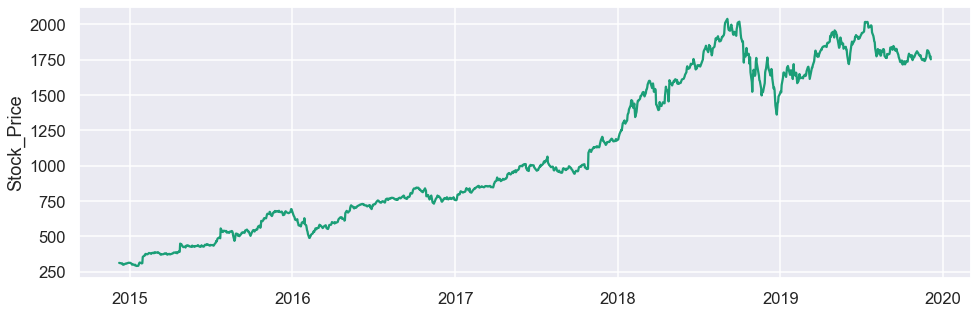

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16,5))
ax1.plot(X.index,X['Stock_Price'])
ax1.set_ylabel('Stock_Price')

In [19]:
y = X.Stock_Price

In [20]:
X.drop(['Stock_Price'],inplace = True,axis=1)

In [21]:
rf = RandomForest(x=X,y=y,n_trees=30,n_features=3,sample_sz=100)

In [22]:
tree = rf.create_tree()

In [23]:
y_pred = rf.predict(X.tail(90).values)

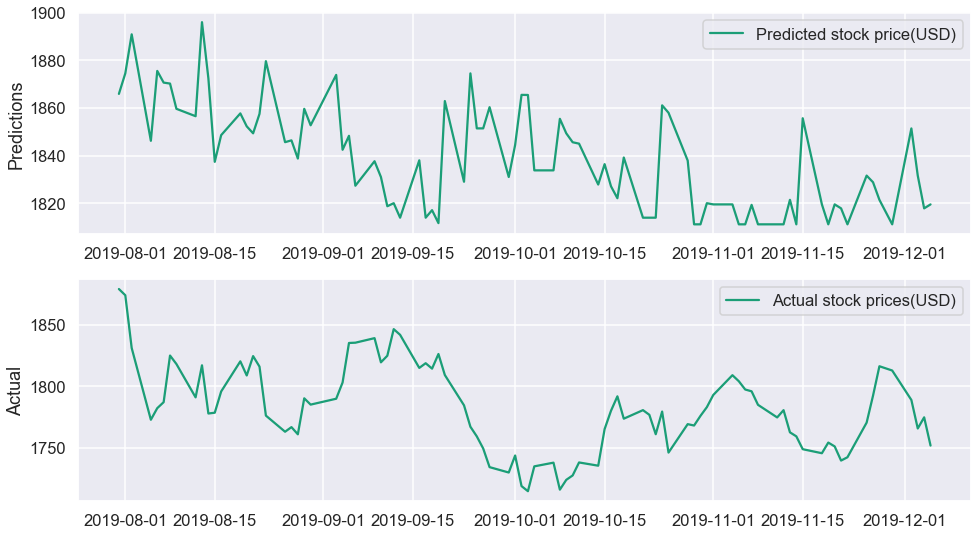

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.plot(X.tail(90).index,y_pred,label="Predicted stock price(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.plot(X.tail(90).index,y.tail(90),label="Actual stock prices(USD)")
ax2.legend(loc='best')

In [25]:
ema_short = X.ewm(span=7, adjust=False).mean()

In [26]:
y_short = y.ewm(span=7, adjust=False).mean()

In [27]:
rf2 = RandomForest(x=ema_short,y=y_short,n_trees=30,n_features=3,sample_sz=100)

In [28]:
y_pred_short = rf.predict(ema_short.tail(90).values)

In [29]:
rf2.create_tree()

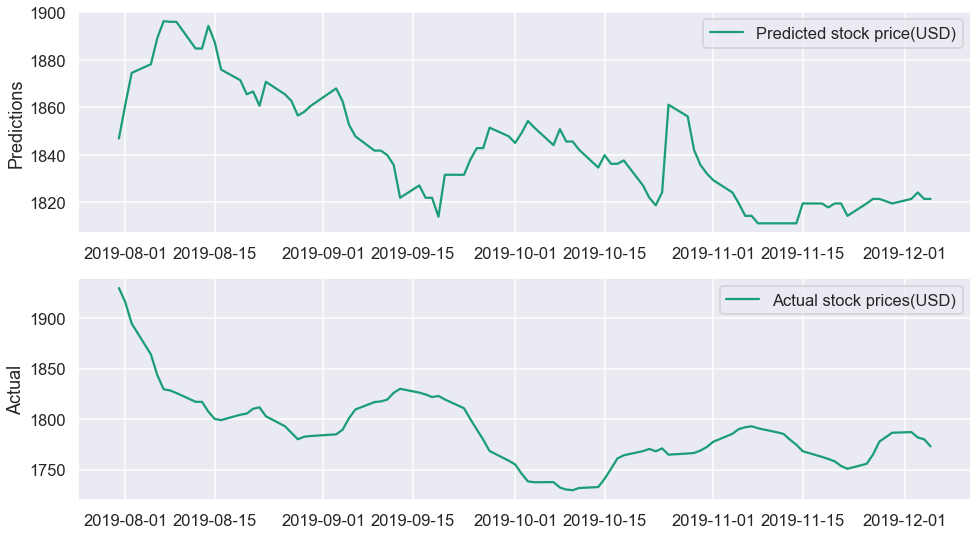

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.plot(ema_short.tail(90).index,y_pred_short,label="Predicted stock price(USD)")
ax2.plot(X.tail(90).index,y_short.tail(90),label="Actual stock prices(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [31]:
trading_signal_week = pd.DataFrame(np.sign(np.diff(y_pred_short)),index=X.tail(89).index,columns=["signal"])

In [32]:
trading_signal_week.head()

,signal
Date,
2019-08-01,1.0
2019-08-02,1.0
2019-08-05,1.0
2019-08-06,1.0
2019-08-07,1.0


In [33]:
X.head()

,Volume,SP500
Date,,
2014-12-08,3639200,-1.066512
2014-12-09,4049500,-1.102944
2014-12-10,3245900,-1.136603
2014-12-11,3262900,-1.132177
2014-12-12,3153500,-1.207366


In [34]:
trading_signal_week = trading_signal_week.shift(1)

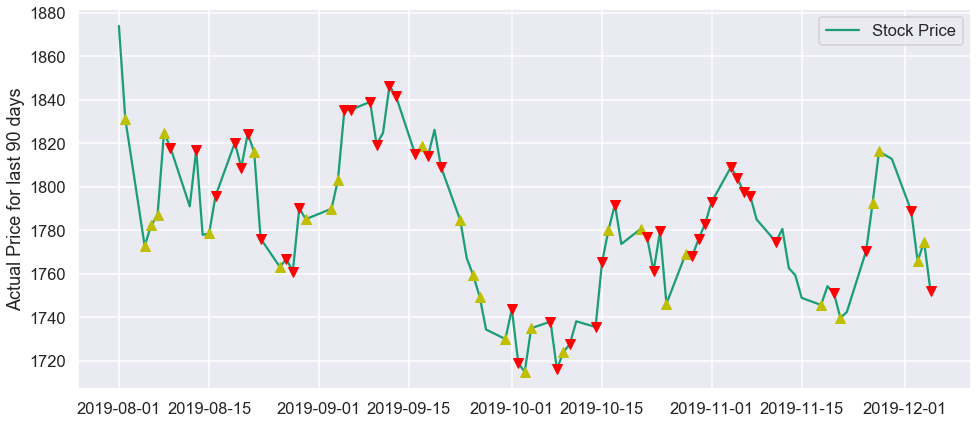

In [35]:
fig, (ax2) = plt.subplots(1, 1, figsize=(16,7))
duration = 89
y_temp = pd.DataFrame(y_short.tail(duration),index =X.tail(duration).index)
ax2.plot(X.tail(duration).index,y.tail(duration),label="Stock Price")

ax2.set_ylabel("Actual Price for last 90 days")

ax2.legend(loc='best')

# # Plot the buy signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == 1.0].index, 
         y.tail(duration)[trading_signal_week.signal == 1.0],'^', markersize=10, color='y')

# Plot the sell signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == -1.0].tail(duration).index, 
         y.tail(duration)[trading_signal_week.signal == -1.0],'v', markersize=10, color='r')

In [44]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame 'positions'
positions = pd.DataFrame(index=trading_signal_week.index).fillna(0.0)

# Buy
positions['stock_price'] = trading_signal_week['signal'] 
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(y_short.tail(90), axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(y_short.tail(90), axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(y_short.tail(90), axis=0)).sum(axis=1).cumsum()   

# Add 'total' & 'returns' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

In [45]:
portfolio = portfolio.loc["2019-08-01":]

In [46]:
portfolio

,stock_price,holdings,cash,total,returns
Date,,,,,
2019-08-01,NaN,0.000000,10000.000000,10000.000000,0.000000e+00
2019-08-02,1894.561799,1894.561799,10000.000000,11894.561799,1.894562e-01
2019-08-05,1864.124482,1864.124482,10000.000000,11864.124482,-2.558927e-03
2019-08-06,1843.641488,1843.641488,10000.000000,11843.641488,-1.726465e-03
2019-08-07,1829.497374,1829.497374,10000.000000,11829.497374,-1.194237e-03
2019-08-08,1828.343032,1828.343032,10000.000000,11828.343032,-9.758168e-05
2019-08-09,-1825.756015,-1825.756015,13651.512030,11825.756015,-2.187134e-04
2019-08-12,0.000000,0.000000,11834.452518,11834.452518,7.353867e-04
2019-08-13,-1817.033380,-1817.033380,13651.485899,11834.452518,0.000000e+00


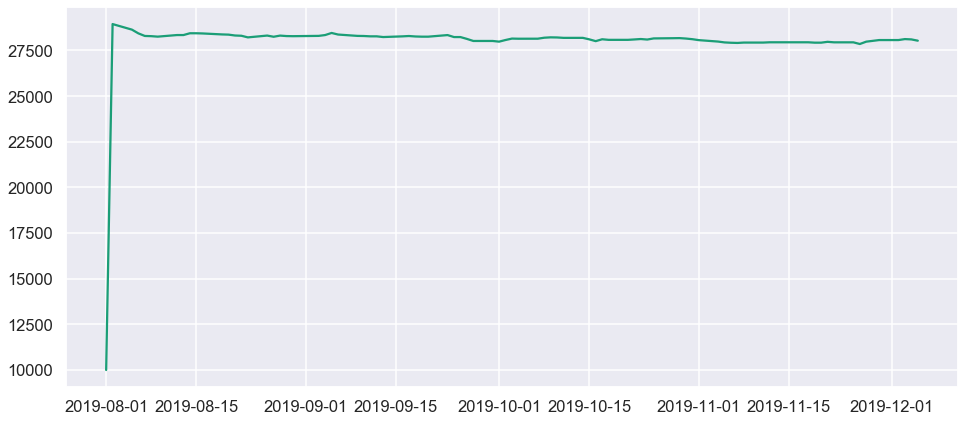

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(16,7))
duration = 89
ax1.plot(portfolio['total'])

In [51]:
# Isolate the returns of the strategy
returns = portfolio['returns']

# 90 day Sharpe ratio
sharpe_ratio = np.sqrt(90) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.9641108726772146


In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_short.tail(90), y_pred_short))

In [53]:
rms

65.4417621229045